Step 1: Import Libraries and Load the Dataset

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# Load the dataset
df = pd.read_csv("./interrelated_predictive_maintenance_ev_dataset (1).xls")

# Display the first few rows of the dataset
df.head()


,Station_ID,Temperature_C,Humidity_Percent,Power_Usage_kWh,Connection_Time_Minutes,Charging_Sessions_Daily,Faults_Per_Week,Downtime_Minutes,Maintenance_Cost_USD,Usage_Efficiency_Percent,Peak_Hours_Usage_kWh,Non_Peak_Hours_Usage_kWh,Number_of_Chargers,Charger_Age_Years,Error_Count_Monthly,Weather_Condition,Energy_Cost_Per_kWh,Customer_Satisfaction_Score,Time_to_Next_Maintenance_Days,Fault_Probability
0,52,24.56,68.23,33.08,374,17,2,21.807450,192.75,68.60,19.85,13.23,9,11,5,Rainy,0.29,5.25,176.15,0.0214
1,93,42.11,59.69,6.08,66,3,0,9.290220,88.54,92.35,3.65,2.43,15,2,1,Rainy,0.29,8.69,179.23,0.0043
2,15,17.33,67.85,3.24,66,3,2,23.552780,194.60,72.22,1.94,1.30,12,8,6,Rainy,0.43,5.26,176.89,0.0173
3,72,39.87,20.20,79.86,814,37,1,14.223831,108.96,71.39,47.92,31.94,10,13,2,Cloudy,0.42,6.65,176.02,0.0221
4,61,25.47,85.16,40.60,374,17,2,27.336569,205.89,79.33,24.36,16.24,4,2,5,Sunny,0.16,5.23,178.34,0.0092


Step 2: Data Preprocessing

In [16]:
# Step 1: Check for Missing Values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.select_dtypes(include="object").mode().iloc[0], inplace=True)

# Step 2: Outlier Detection
def clip_outliers(column, n_std=3):
    mean = column.mean()
    std = column.std()
    return np.clip(column, mean - n_std * std, mean + n_std * std)

# Apply clipping to numeric columns
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
for col in numeric_columns:
    df[col] = clip_outliers(df[col])

# Step 3: Feature Scaling and Categorical Encoding
X = df.drop(columns=["Time_to_Next_Maintenance_Days", "Fault_Probability", "Usage_Efficiency_Percent"])
y_maintenance = df["Time_to_Next_Maintenance_Days"]
y_fault_prob = df["Fault_Probability"]
y_efficiency = df["Usage_Efficiency_Percent"]

# Identify categorical and numerical features
categorical_features = ["Weather_Condition"]
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

# Preprocess features
X_preprocessed = preprocessor.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train_maintenance, y_test_maintenance = train_test_split(
    X_preprocessed, y_maintenance, test_size=0.2, random_state=42
)
_, _, y_train_fault, y_test_fault = train_test_split(
    X_preprocessed, y_fault_prob, test_size=0.2, random_state=42
)
_, _, y_train_eff, y_test_eff = train_test_split(
    X_preprocessed, y_efficiency, test_size=0.2, random_state=42
)


Step 3: Data Visualization (EDA)

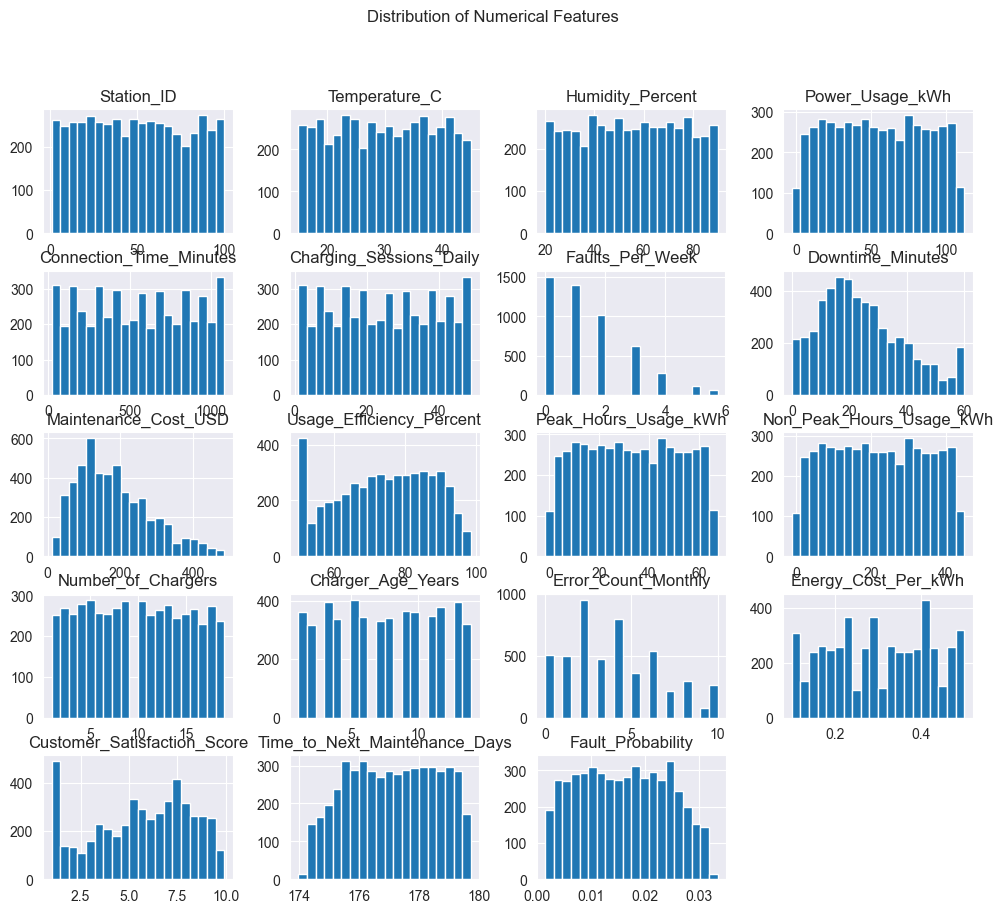

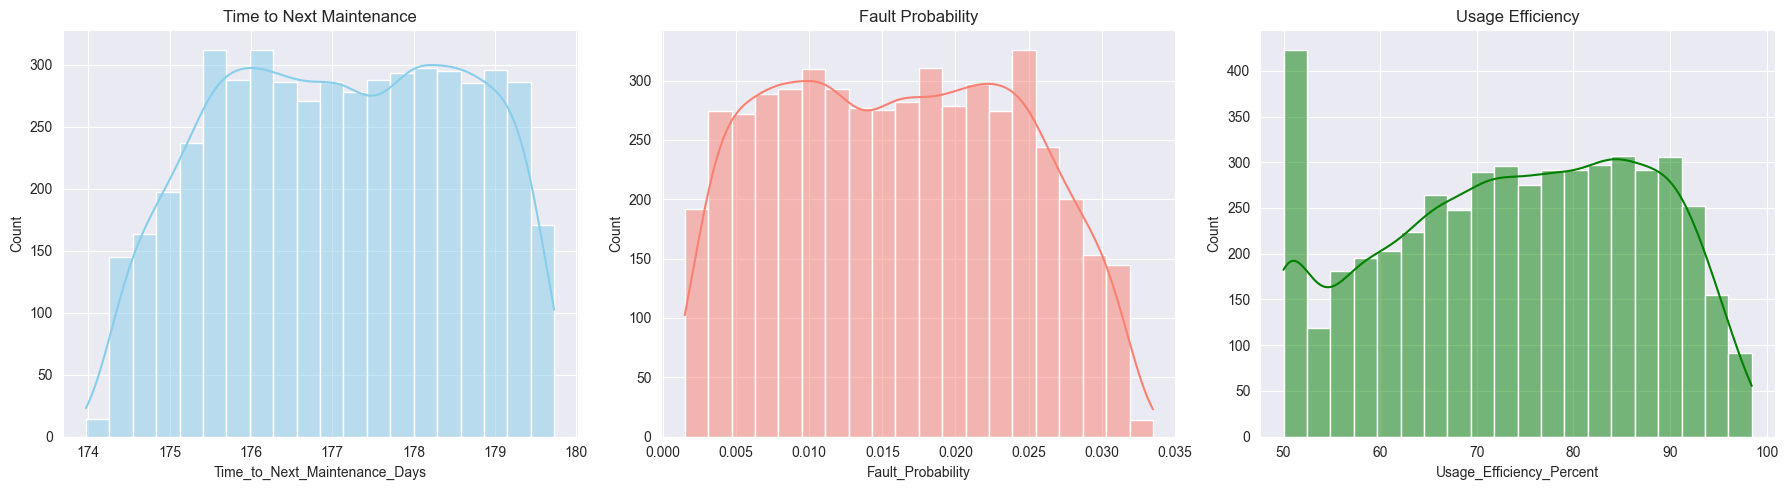

In [17]:
# Visualize the distribution of numerical features
df[numeric_columns].hist(figsize=(12, 10), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Visualize the distribution of target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df["Time_to_Next_Maintenance_Days"], kde=True, ax=axes[0], color="skyblue").set_title('Time to Next Maintenance')
sns.histplot(df["Fault_Probability"], kde=True, ax=axes[1], color="salmon").set_title('Fault Probability')
sns.histplot(df["Usage_Efficiency_Percent"], kde=True, ax=axes[2], color="green").set_title('Usage Efficiency')

plt.tight_layout()
plt.show()


Visualizing Correlations Between Features

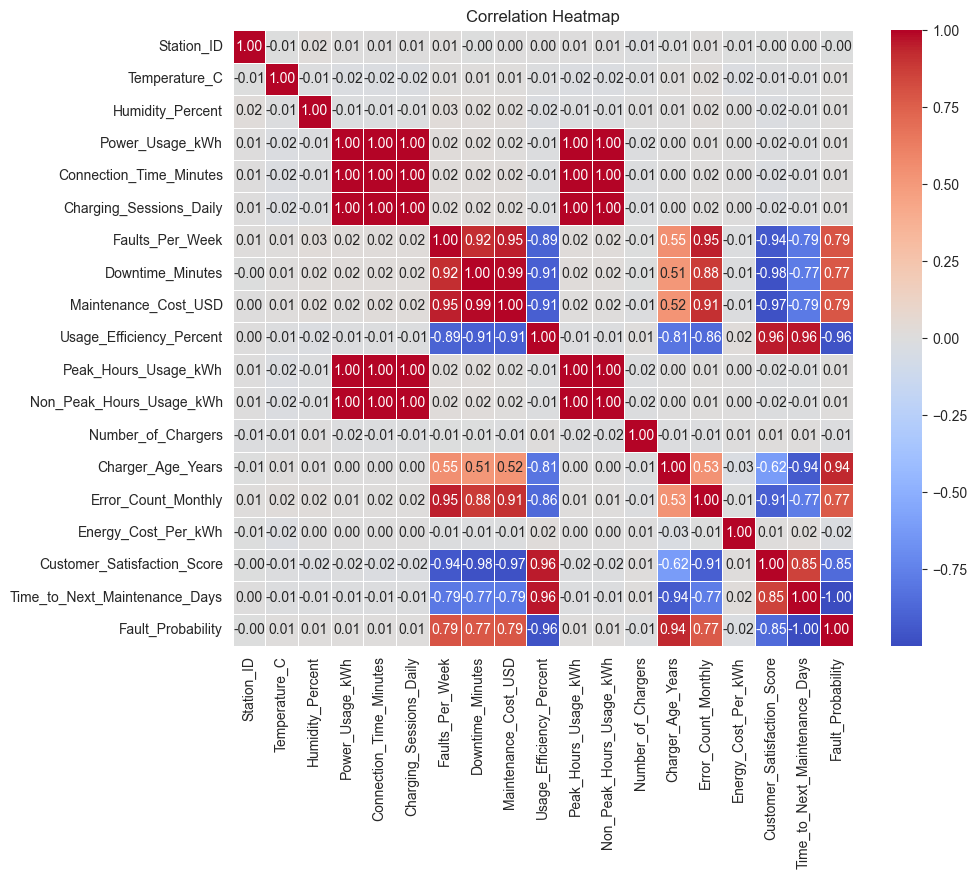

In [18]:
# Compute correlation matrix
# Exclude non-numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Visualizing Categorical Features

C:\Users\tarun\AppData\Local\Temp\ipykernel_18736\1362949824.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Weather_Condition", data=df, palette="Set2")


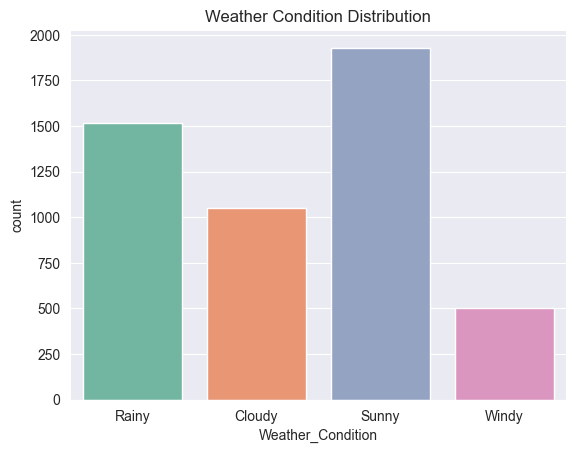

In [19]:
# Visualize distribution of categorical features
sns.countplot(x="Weather_Condition", data=df, palette="Set2")
plt.title("Weather Condition Distribution")
plt.show()


Step 4: Model Selection

In [20]:
# Initialize models
maintenance_model = GradientBoostingRegressor(random_state=42)
fault_model = RandomForestRegressor(random_state=42)
efficiency_model = GradientBoostingRegressor(random_state=42)


Step 5: Model Training

In [21]:
# Train the models
maintenance_model.fit(X_train, y_train_maintenance)
fault_model.fit(X_train, y_train_fault)
efficiency_model.fit(X_train, y_train_eff)


GradientBoostingRegressor(random_state=42)

Step 6: Model Evaluation

In [22]:
# Predict on test set
y_pred_maintenance = maintenance_model.predict(X_test)
y_pred_fault = fault_model.predict(X_test)
y_pred_efficiency = efficiency_model.predict(X_test)

# Evaluate performance
mae_maintenance = mean_absolute_error(y_test_maintenance, y_pred_maintenance)
mae_fault = mean_absolute_error(y_test_fault, y_pred_fault)
mae_efficiency = mean_absolute_error(y_test_eff, y_pred_efficiency)

print(f"MAE for Time to Next Maintenance: {mae_maintenance}")
print(f"MAE for Fault Probability: {mae_fault}")
print(f"MAE for Usage Efficiency: {mae_efficiency}")


MAE for Time to Next Maintenance: 0.033658739300760514
MAE for Fault Probability: 7.358899999999985e-05
MAE for Usage Efficiency: 0.33118939796923785


# Step 7: Visualizing Model Predictions
Time to Next Maintenance Predictions

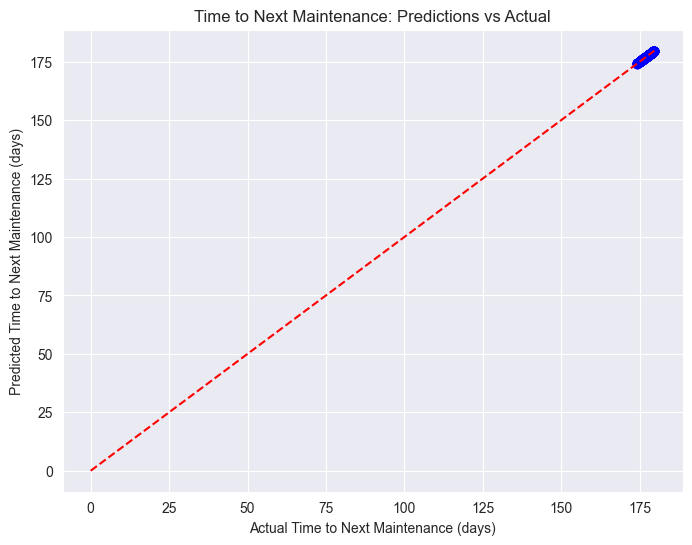

In [23]:
# Plot predictions vs actual values for maintenance prediction
plt.figure(figsize=(8, 6))
plt.scatter(y_test_maintenance, y_pred_maintenance, color="blue", alpha=0.5)
plt.plot([0, max(y_test_maintenance)], [0, max(y_pred_maintenance)], color="red", linestyle="--")
plt.title("Time to Next Maintenance: Predictions vs Actual")
plt.xlabel("Actual Time to Next Maintenance (days)")
plt.ylabel("Predicted Time to Next Maintenance (days)")
plt.show()


Fault Probability Predictions

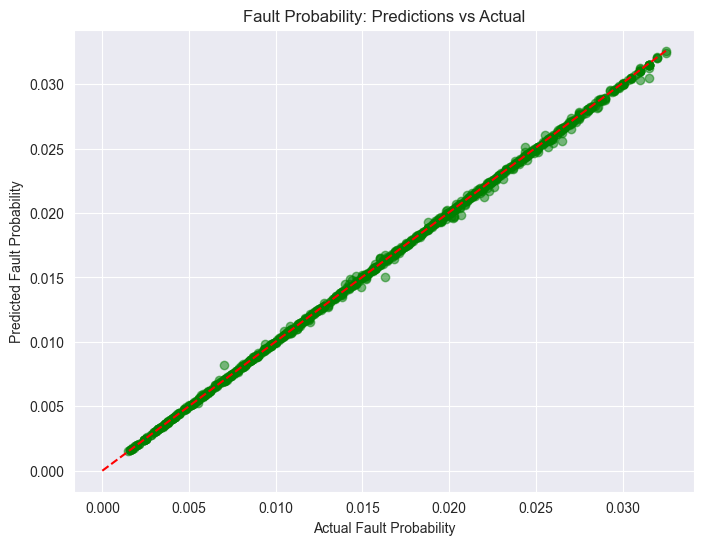

In [24]:
# Plot predictions vs actual values for fault probability
plt.figure(figsize=(8, 6))
plt.scatter(y_test_fault, y_pred_fault, color="green", alpha=0.5)
plt.plot([0, max(y_test_fault)], [0, max(y_pred_fault)], color="red", linestyle="--")
plt.title("Fault Probability: Predictions vs Actual")
plt.xlabel("Actual Fault Probability")
plt.ylabel("Predicted Fault Probability")
plt.show()


Usage Efficiency Predictions

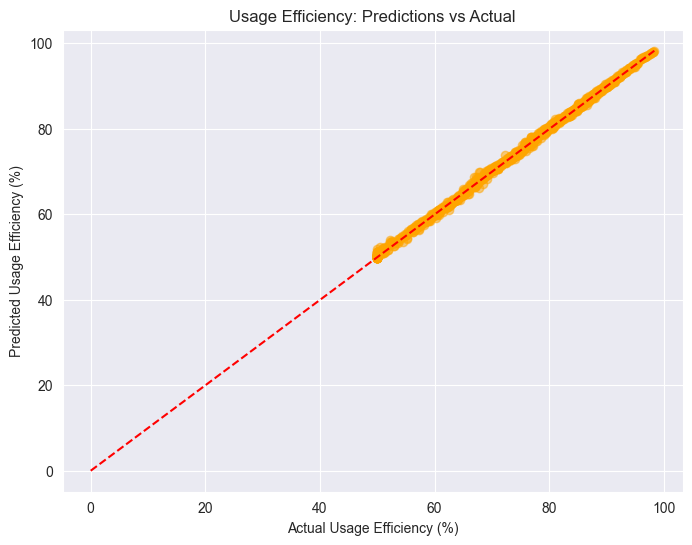

In [25]:
# Plot predictions vs actual values for usage efficiency
plt.figure(figsize=(8, 6))
plt.scatter(y_test_eff, y_pred_efficiency, color="orange", alpha=0.5)
plt.plot([0, max(y_test_eff)], [0, max(y_pred_efficiency)], color="red", linestyle="--")
plt.title("Usage Efficiency: Predictions vs Actual")
plt.xlabel("Actual Usage Efficiency (%)")
plt.ylabel("Predicted Usage Efficiency (%)")
plt.show()


Step 8: Model Performance Metrics Visualization

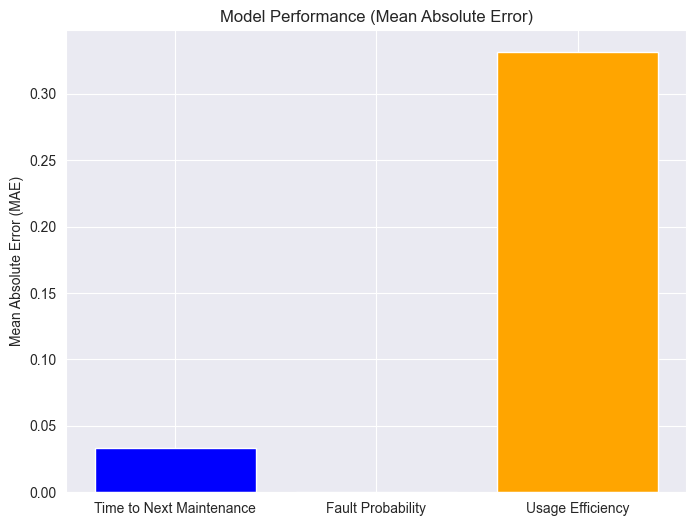

In [26]:
# Model performance metrics visualization
metrics = {
    "Time to Next Maintenance": mae_maintenance,
    "Fault Probability": mae_fault,
    "Usage Efficiency": mae_efficiency
}

# Plot the performance metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange'])
plt.title("Model Performance (Mean Absolute Error)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()


Step 10: Save the Model for Deployment

In [27]:
# Save models
joblib.dump(maintenance_model, "../models/maintenance_model.pkl")
joblib.dump(fault_model, "../models/fault_model.pkl")
joblib.dump(efficiency_model, "../models/efficiency_model.pkl")
joblib.dump(preprocessor, "../models/preprocessor.pkl")  # Save preprocessor too


['../models/preprocessor.pkl']